# JUSTICE IAM Introduction 

##### Setting Some Dummy Policy Levers

JUSTICE model has two policy levers: Savings rate and Emissions Control Rate. To run the simulation version of the model, we need to feed the policy levers with some values. The range of both savings rate and emissions control rate are from 0 to 1.0 corresponding to 0% to 100%. 

Here we set the savings rate to the intial savings rate data of the different regions and increase it linearly to the optimal savings rate of original DICE/RICE implementation

##### Lever: Linear Emissions Control Rate

Here the emission control starts at 0, meaning no emission control and increases linearly to 100% emission control rate depending on the transistion start year and the full emission control year.

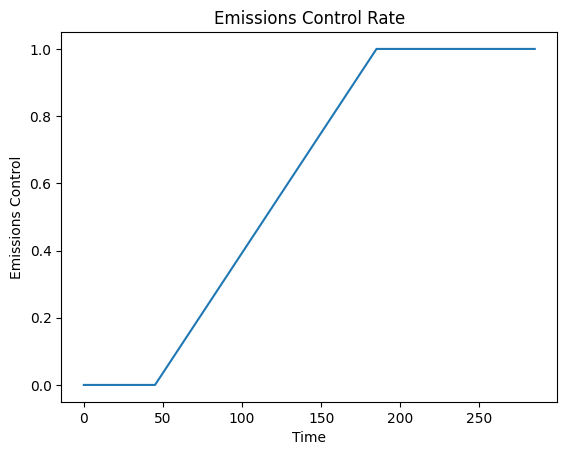

In [1]:
import numpy as np
from justice.util.data_loader import DataLoader
from justice.util.enumerations import *
from matplotlib import pyplot as plt
from justice.util.model_time import TimeHorizon

# Load the data
data_loader = DataLoader()

# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

#emissions control rate borrowed from emissions module

#Variables to be changed/deleted later
miu_initial = 0.0
min_miu = 0.0 #0.0 #1.0
min_miu_year = 2060 #9-original #8 in this model  # 2060
max_miu = 1.0
max_miu_year = 2200 #38-original #37 in this model #2205

t_min_miu = time_horizon.year_to_timestep(min_miu_year, timestep=1)
t_max_miu = time_horizon.year_to_timestep(max_miu_year, timestep=1)

#Initialize emissions control rate
emissions_control_rate = np.zeros((len(data_loader.REGION_LIST), len(time_horizon.model_time_horizon)))

for t in range(len(time_horizon.model_time_horizon)):
    
    if t < t_min_miu:       # Before time of transition
        emissions_control_rate[:,t] = min_miu
    elif t <= t_max_miu:   # Transition
        # During the transition
        emissions_control_rate[:, t] = min_miu + (max_miu - min_miu) * (t - t_min_miu)/(t_max_miu - t_min_miu)
    else:                   # After the transition
        emissions_control_rate[:, t] = max_miu


plt.plot(emissions_control_rate[0, :])
plt.title("Emissions Control Rate")
plt.xlabel("Time")
plt.ylabel("Emissions Control")
plt.show()

### JUSTICE Initialization and Run

In [2]:
from justice.model import JUSTICE
from justice.util.enumerations import *

# Instantiate the model
scenarios = 2
model = JUSTICE(
        scenario =scenarios,
        economy_type=Economy.NEOCLASSICAL,
        damage_function_type=DamageFunction.KALKUHL,
        abatement_type=Abatement.ENERDATA,
        social_welfare_function=WelfareFunction.UTILITARIAN,
        # climate_ensembles=[887, 899, 763, 4, 454, 728, 942, 543, 510, 913, 972, 384, 108, 899, 644, 607, 480, 260, 740, 177, 230, 531, 681, 468, 798, 835, 974, 401, 3, 517, 160, 151, 408, 274, 460, 541, 549, 377, 899, 278, 228, 972, 926, 116, 156, 189, 396, 414, 907, 284, 452, 510, 4, 636, 956, 859, 252, 785, 864, 299, 787, 894, 472, 254, 918, 924, 937, 95, 456, 599, 625, 485, 206, 694, 835, 376, 999, 30, 374, 729, 935, 816, 763, 136, 134, 114, 50, 533, 788, 745, 684, 510, 510, 763, 212, 364, 875, 731, 401, 476],
        stochastic_run=False, # @OPTIONAL: This is to run the FaIR model in stochastic mode. Default is True 
    )

# Run the model
model.run(emission_control_rate = emissions_control_rate, endogenous_savings_rate=True)

# Extract the data
datasets = model.evaluate() # Get the results of the simulation run


/Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Visualize the Output Data

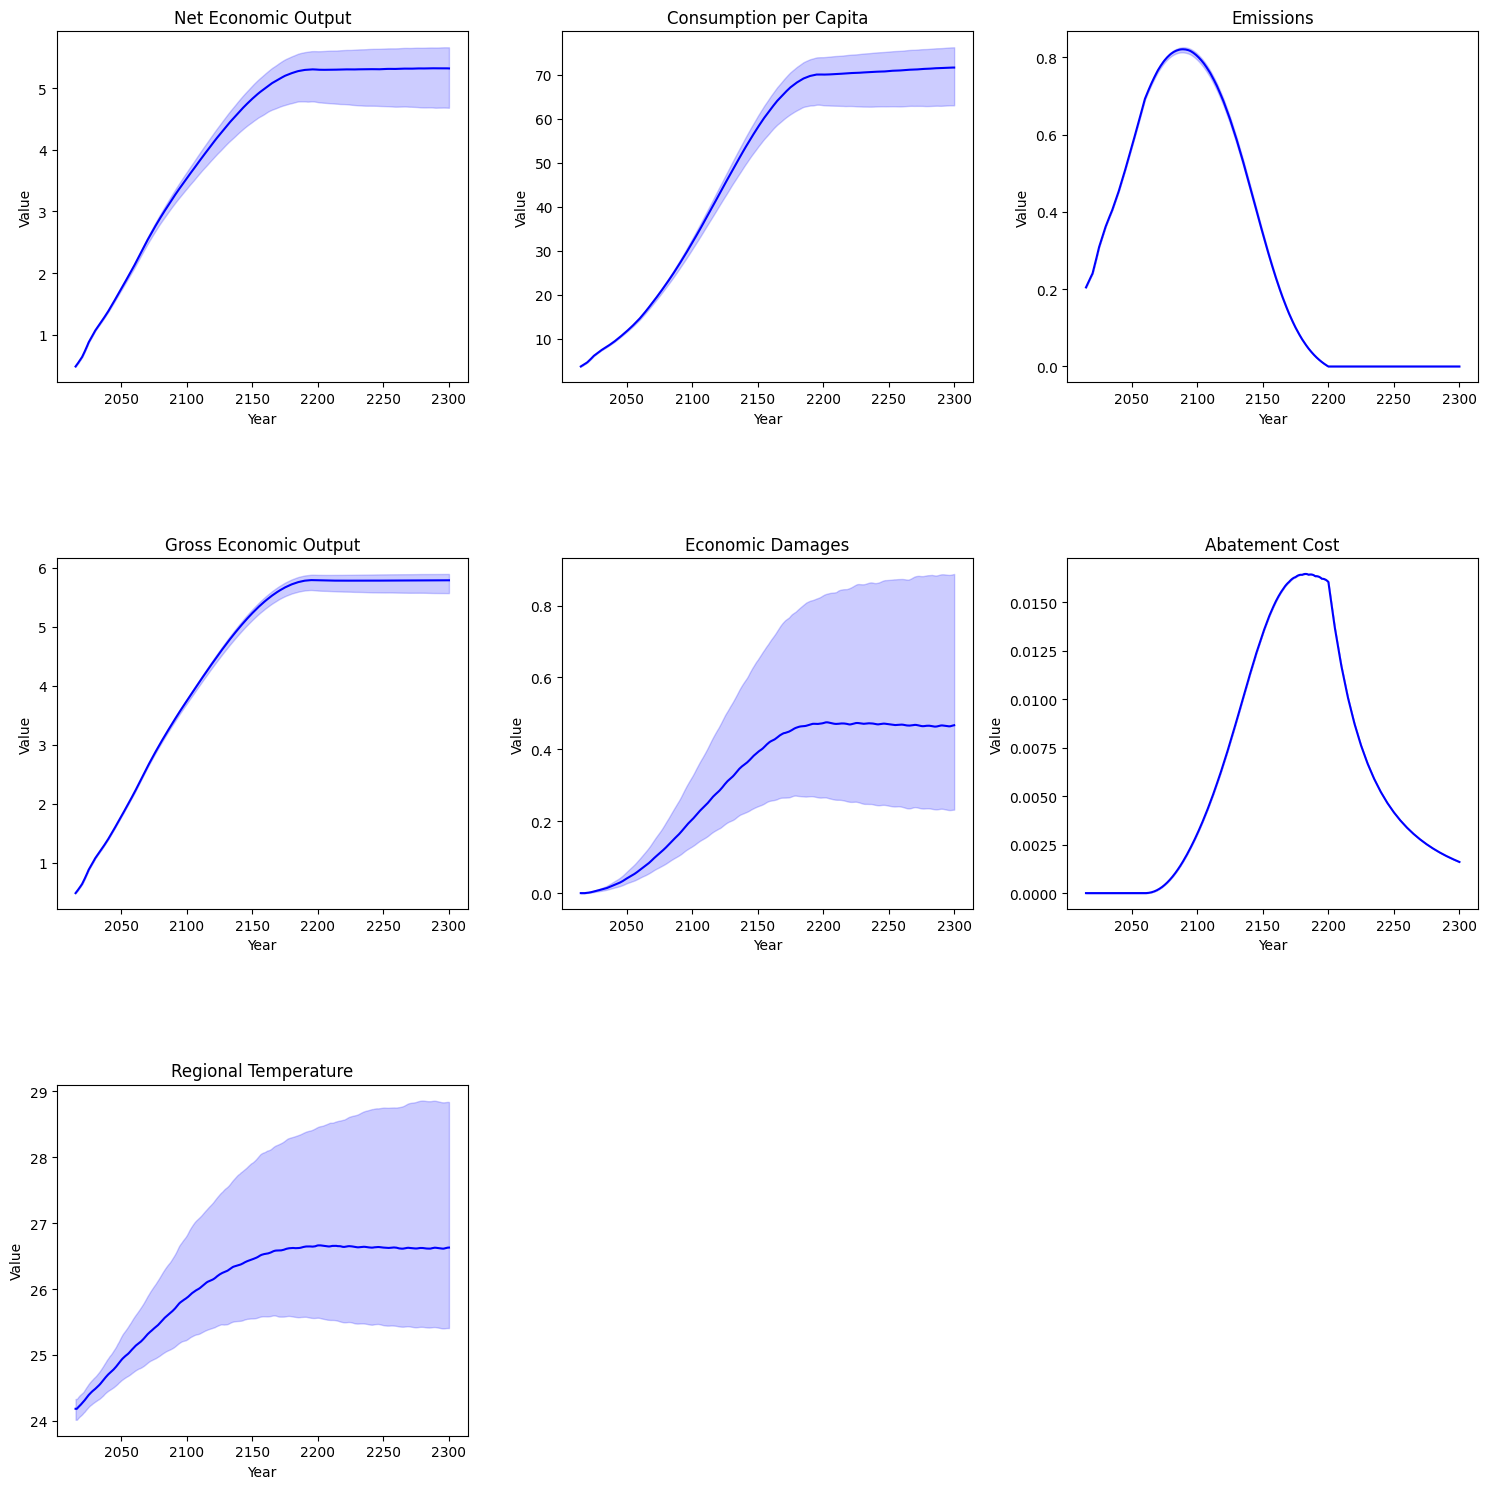

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Load the data from datasets dictionary
gross_output = datasets['gross_economic_output'] 
net_output = datasets['net_economic_output']

cpc = datasets['consumption_per_capita'] #(57, 286, 1001)
emis_control = datasets['emissions'] #(57, 286, 1001)
reg_temp = datasets['regional_temperature']
temp = datasets['global_temperature'] # (286, 1001)
damages = datasets['economic_damage'] #(57, 286, 1001)
abatecost = datasets['abatement_cost'] #(57, 286, 1001)

# Create list of all the data arrays
data_list = [net_output, cpc, emis_control, gross_output, damages, abatecost, reg_temp]
titles = ['Net Economic Output', 'Consumption per Capita', 'Emissions', 'Gross Economic Output', 'Economic Damages', 'Abatement Cost', 'Regional Temperature']

region_index = 55

# Create a figure with 3 rows and 3 columns
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axs array to iterate over it
axs = axs.flatten()

# Iterate over the data arrays and plot them
for i, loaded_data in enumerate(data_list):
    # Select the region based on region_index
    region_data = loaded_data[region_index, :, :]

    # Calculate the 5th, 50th (median), and 95th percentiles
    p5 = np.percentile(region_data, 5, axis=1)
    p50 = np.percentile(region_data, 50, axis=1)
    p95 = np.percentile(region_data, 95, axis=1)

    # Plot the envelope
    axs[i].fill_between(time_horizon.model_time_horizon, p5, p95, color='b', alpha=0.2)

    # Plot the median line
    sns.lineplot(x=time_horizon.model_time_horizon, y=p50, ax=axs[i], color='b')

    # Set the title and axis labels
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Value')

# Remove the unused subplots
for i in range(len(data_list), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout and spacing
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()





### Plot the global temperature projections

FaIR climate model has 1001 ensemble members to represent climate uncertainty. We can select a subset of the ensemble members to speed up JUSTICE simulation. Here we select 50 ensemble members for the simulation.

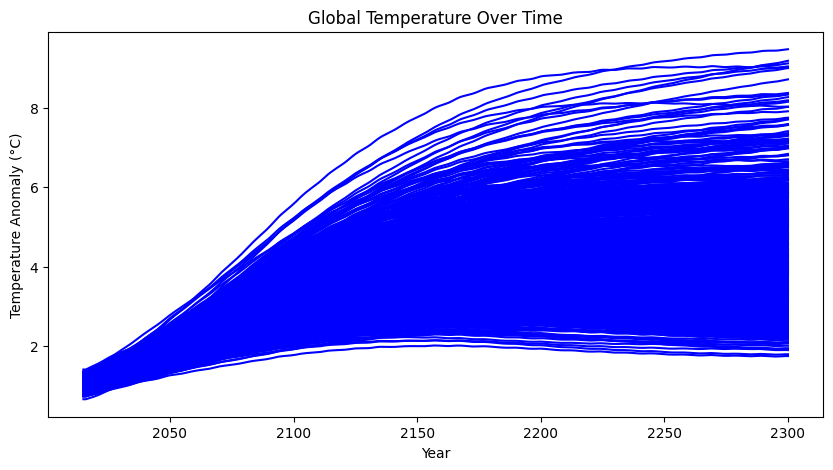

Representative indexes: [384 236 810 886   1 669 580 610 946 151 543 109 692 952  89 574 991 976
 296 855 770 980 632 932 513 695 360 355 177 578 848 189 204 118 284 766
 212 985 786   5 274 158 197 349 116 247 982  81 298 625]
Representative indexes (1-based): [385 237 811 887   2 670 581 611 947 152 544 110 693 953  90 575 992 977
 297 856 771 981 633 933 514 696 361 356 178 579 849 190 205 119 285 767
 213 986 787   6 275 159 198 350 117 248 983  82 299 626]


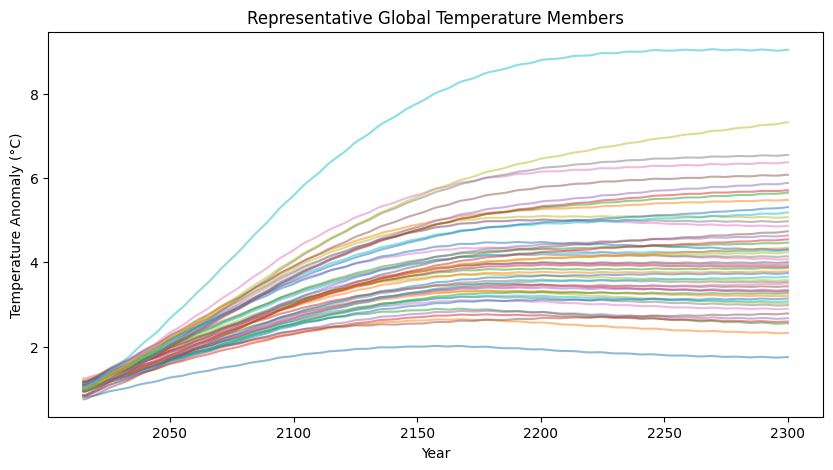

In [4]:
# Plot the temperature data
plt.figure(figsize=(10, 5))
plt.plot(time_horizon.model_time_horizon, temp, label='Global Temperature', color='blue')
plt.title('Global Temperature Over Time')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.show()

summaries = temp[-1, :]

N = 50  # number of members you want
quantile_indexes = np.argsort(summaries)
representative_indexes = []

for i in range(N):
    start = int(i * (1001 / N))
    end = int((i+1) * (1001 / N))
    idx_in_quantile = np.random.choice(quantile_indexes[start:end])
    representative_indexes.append(idx_in_quantile)

representative_indexes = np.array(representative_indexes)
print("Representative indexes:", representative_indexes)

# Print indexes but by adding 1 to each index for better readability
print("Representative indexes (1-based):", representative_indexes + 1)

# Now plot the subset of representative members
plt.figure(figsize=(10, 5))
for idx in representative_indexes:
    plt.plot(time_horizon.model_time_horizon, temp[:, idx], label=f'Member {idx}', alpha=0.5)
plt.title('Representative Global Temperature Members')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.show()


### Optimizing the Policy Levers Based on Different Principles of Distributive Justice